In [1]:
!nvidia-smi

Wed Jun 21 07:19:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 45%   31C    P8    N/A /  75W |    691MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import Libary
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from matplotlib.ticker import MaxNLocator

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from wordcloud import WordCloud

import gensim
from gensim import models
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases, CoherenceModel
import gensim.corpora as corpora

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

import pyLDAvis.gensim

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Load Dataset

In [3]:
# Load Dataset
df = pd.read_csv("../dataset/dataset_preprocess_without_stopwords_stemming.csv")
# df = pd.read_csv("../dataset/dataset_preprocess.csv")

In [4]:
# Show first 5 rows
df.head()

,id,text_preprocess,tokens,len_char,len_word,len_token
0,47d0cdd937754bd6b860f89b2bab1dbb,akses jalannya waktu itu masih sulit di jangka...,"['akses', 'jalannya', 'waktu', 'itu', 'masih',...",84,13,12
1,4804acd6c05e4f89b098e2ca35019419,perjalanan yg bnr bikin syahduu dr tempat park...,"['perjalanan', 'bnr', 'bikin', 'syahduu', 'tem...",110,19,15
2,61037dbdb7b14045be49d4494e95cf05,mei touring bari mudik mntap perjalanan sungg...,"['mei', 'touring', 'bari', 'mudik', 'mntap', '...",162,25,20
3,a2c9e817e2b949c6880f971f43a11d2f,perjalanan touring motor dari bekasi melewati ...,"['perjalanan', 'touring', 'motor', 'dari', 'be...",152,23,22
4,772bd029c2ce450b94b6fc6f524fbc05,nyampe lnjut kebawah jam mantap suasana safar,"['nyampe', 'lnjut', 'kebawah', 'jam', 'mantap'...",46,8,7


In [5]:
df['tokens'] = df['tokens'].apply(lambda x: eval(x))

# Preprocessing

## Stopwords

In [6]:
''' Stopword by Sastrawi '''

# stop_words = StopWordRemoverFactory().get_stop_words()
# extend_stopword = [
#     'pas', 'yg', 'tp', 'rb', 'km', 'tp', 'dg', 'dr',
#     'bagu','bagus','bagusnya',
#     'banyaknya','banyakny','banyak',
#     'jlan','jalan',
#     'masuk','tempat',
#     'atas','sana','karna','sama','saya','sudah','udah','mungkin', 'tuji','jadi','saja','sini','kalo','kalau',
#     'untuk','semua','buat','bisa','cuma','sangat','buat','unutk','paling','cukup','naik','ribu','sekali',
#     'benar','kesini','turun','sera','sayangny','anjur','mending','dapat', 'punya','mana','sekitar',
#     'dapet','coba','bukan','sebut','sampe','tuju','hingga','beberapa','banget',
#     'utk','gak','adl','dll','coba','klo','nya','pas','per','bnr','udh','lua','aja','bgt','lalu','krn','mau',
# ]

# stop_words += extend_stopword

' Stopword by Sastrawi '

In [7]:
''' Stopword by NLTK '''

stop_words = stopwords.words('indonesian')
# stop_words = sorted(list(set(stopwords.words('indonesian')) - set(['jauh'])))
stop_words = sorted(list(set(stopwords.words('indonesian')) - set(['baik', 'dekat', 'jauh', 'kurang', 'tidak'])))
stop_words.extend([
    'terima', 'kasih',
    'ala', 'pas', 'yg', 'tp', 'rb', 'km', 'tp', 'dg', 'dr', 'nya', 'pada', 'jgn', 'lupa',
    'ada', 'akang', 'ato', 'atw', 'ayo', 'dar', 'sih', 'loh', 'yaa', 'yah',
    'orchid', 'forest', 'tangkuban', 'floating', 'market', 'bandung', 'grafika', 'cikole', 
    'parahu', 'jawa', 'kabupaten', 'barat', 'cic', 'lembang', 'dayang', 'sumbi',
    # 'bagu','bagus','bagusnya',
    # 'banyaknya','banyakny','banyak',
    # 'jlan','jalan',
    # 'masuk','tempat',
    'atas','ats', 'sana','karna','sama','saya', 'salah', 'sudah','udah','mungkin', 'tuji','jadi','saja','sini','kalo','kalau',
    'untuk','semua','buat','bisa','cuma','sangat','buat','unutk','paling','cukup','naik','ribu','sekali',
    'benar','bener','kesini','turun','sera','sayangny','anjur','mending','dapat', 'punya','mana','sekitar',
    'dapet','coba','bukan','sebut','sampe','tuju','hingga','beberapa','banget',
    'utk','gak','adl','dll','coba','klo','nya','pas','per','bnr','udh','lua','aja','bgt','lalu','krn','mau',
])

In [8]:
len(stop_words)

860

In [9]:
df['tokens'] = df['tokens'].apply(lambda x: [w for w in x if not w in stop_words])

In [10]:
# prev = df.loc[df['id'] == '82a4d407f287440d81e804e96c044a18', 'tokens'].values
# prev

## Stemming

In [11]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [12]:
df['tokens'] = df['tokens'].apply(lambda x: stemmer.stem(' '.join(x)).split(' '))

# Data Transformation

In [13]:
# df['tokens'] = df['tokens'].apply(lambda x: ' '.join(x))

In [14]:
texts = df['tokens']
texts = texts.reset_index(drop=True)

In [15]:
# texts = list(texts)

In [16]:
# for id_text in range(len(texts)):
#     for id_word in range(len(texts[id_text])-1):
#         first_id, second_id = id_word, first_id + 1
        
#         for i in range(len(texts)):
#             word_i = texts[i].index(texts[id_text][first_id]) 
#             if texts[i][word_i+1] == texts[id_text][second_id] 
                

## Bigram & Trigram Models

In [17]:
# (15, 20)
# (13, 17)
# (10, 25)
# (10, 20)
bigram = Phrases(texts, min_count=10, threshold=25)
# trigram = Phrases(bigram[texts])

for idx in range(len(texts)):
    for token in bigram[texts[idx]]:
        if '_' in token:
            texts[idx].append(token)
    # for token in trigram[texts[idx]]:
    #     if '_' in token:
    #         texts[idx].append(token)

In [18]:
texts_new = []
for id_text in range(len(texts)):
    text = []
    for id_each_word in range(len(texts[id_text])):
        if '_' in texts[id_text][id_each_word]:
            text.append(texts[id_text][id_each_word])
    text = list(set(text))
    if len(text) != 0:
        texts_new.append(text)

In [19]:
texts = texts_new

In [20]:
# len(texts)

In [21]:
# all_words = [' '.join(text) for text in texts]
# all_words = ' '.join(all_words)
# all_words = sorted(list(set(all_words.split())))

In [22]:
# with open("../dataset/unigram_list.txt", "w", encoding="utf-8") as output:
#     output.write(str(all_words))

In [23]:
# all_words[-20:-10]

## Create corpus

In [24]:
# Initiate Corpus
id2word = corpora.Dictionary(texts)
# id2word.filter_extremes(no_below=5, no_above=0.2)

# texts = df['tokens']
# corpus = [id2word.doc2bow(text) for text in texts]

In [25]:
# BoW Corpus
corpus = [id2word.doc2bow(text) for text in texts]

In [26]:
# id2word = corpora.Dictionary(df['tokens'])
# texts = df['tokens']
# corpus = [id2word.doc2bow(text) for text in texts]

In [27]:
# TF-IDF Corpus
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# Apply Model

In [28]:
# alpha = [0.05,0.1,0.5,1,5,10]
# beta = [0.05,0.1,0.5,1,5,10]

In [29]:
def compute_coherence_values(id2word, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel( #LdaModel gensim.models.LdaMulticore
                    corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, iterations=100,
                    # alpha=0.075, eta=0.55,
                    # chunksize=2000, passes=1, update_every=1, alpha='symmetric', eta=None, 
                    # decay=0.5, offset=1.0, eval_every=10, gamma_threshold=0.001
                    )
        
        model_list.append(model)
        coherence_model = CoherenceModel(
                            model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

In [30]:
START = 2
LIMIT = 16
STEP = 1

model_list, coherence_values = compute_coherence_values(
    id2word=id2word, corpus=corpus_tfidf, texts=texts, start=START, limit=LIMIT, step=STEP)

  0%|          | 0/14 [00:00<?, ?it/s]

# Evaluate

## Coherence Score Result

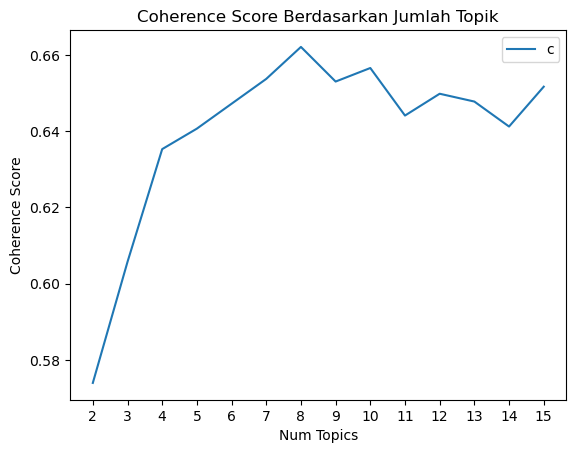

In [31]:
x = range(START, LIMIT, STEP)
plt.plot(x, coherence_values)
plt.title('Coherence Score Berdasarkan Jumlah Topik')
plt.xlabel('Num Topics')
plt.ylabel('Coherence Score')
plt.xticks(range(min(x), max(x)+1))
# plt.ylim(0, 1)
# plt.xlim(0, LIMIT-1)
# plt.xticks(coherence_values, x)
plt.legend(('coherence_values'), loc='best')
plt.show()

In [32]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    # print(f'{cv:.3f}')
    print(f'{m}, {cv:.3f}')
    # print(f'Num topics = {m}, has Coherence Score of {cv:.3f}')

2, 0.574
3, 0.606
4, 0.635
5, 0.641
6, 0.647
7, 0.654
8, 0.662
9, 0.653
10, 0.657
11, 0.644
12, 0.650
13, 0.648
14, 0.641
15, 0.652


# Result

## Preview Sample Model

In [33]:
model = model_list[6]

In [34]:
x = model.show_topics(num_topics=8, num_words=10, formatted=False)
# coherence_ldas = model.get_coherence_per_topic()
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

In [35]:
# # Below Code Prints Topics and Words
# for each_topic_coherence_score in enumerate(coherence_ldas):
#     print(f'Topic {each_topic_coherence_score[0]}: {each_topic_coherence_score[1]:.5f}')

In [36]:
# Below Code Prints Topics and Words
for topic, words in topics_words:
    print(f'{words}')
    # print(f'Topic {topic}: {words}')

['udara_sejuk', 'buang_sampah', 'jagung_bakar', 'bau_belerang', 'nice_place', 'wajib_kunjung', 'long_weekend', 'nge_camp', 'pegawai_ramah', 'kendara_roda']
['udara_segar', 'lepas_penat', 'mudah_jangkau', 'jembatan_gantung', 'kurang_awat', 'suguh_pandang', 'udara_sejuk', 'happy_holiday', 'mini_zoo', 'over_all']
['api_unggun', 'paint_ball', 'flying_fox', 'teman_teman', 'the_best', 'olah_raga', 'baju_hangat', 'kursi_roda', 'siap_fisik', 'cuci_mata']
['musim_hujan', 'panjat_tebing', 'murah_riah', 'angin_kencang', 'pakai_sepatu', 'uji_adrenalin', 'nasi_liwet', 'good_place', 'alangkah_baik', 'cuci_tangan']
['air_terjun', 'layan_ramah', 'pintu_masuk', 'arena_main', 'tugas_ramah', 'tata_rapi', 'pacu_adrenalin', 'food_court', 'betah_lama', 'moga_depan']
['flying_fox', 'family_gathering', 'rekreasi_keluarga', 'bareng_keluarga', 'camping_ground', 'hiruk_pikuk', 'pasar_apung', 'lokasi_strategis', 'taman_kelinci', 'lepas_lelah']
['hutan_pinus', 'pohon_pinus', 'kamar_mandi', 'fasilitas_lengkap', 'ac

In [37]:
# Below Code Prints Topics and Words with probability
for idx, topic in model.print_topics(-1):
    print(f'{topic}')
    # print(f'Topic: {idx}, Word: {topic}')

0.437*"udara_sejuk" + 0.059*"buang_sampah" + 0.055*"jagung_bakar" + 0.051*"bau_belerang" + 0.050*"nice_place" + 0.026*"wajib_kunjung" + 0.023*"long_weekend" + 0.017*"nge_camp" + 0.016*"pegawai_ramah" + 0.015*"kendara_roda"
0.237*"udara_segar" + 0.102*"lepas_penat" + 0.075*"mudah_jangkau" + 0.067*"jembatan_gantung" + 0.047*"kurang_awat" + 0.041*"suguh_pandang" + 0.037*"udara_sejuk" + 0.030*"happy_holiday" + 0.025*"mini_zoo" + 0.025*"over_all"
0.216*"api_unggun" + 0.129*"paint_ball" + 0.081*"flying_fox" + 0.051*"teman_teman" + 0.048*"the_best" + 0.038*"olah_raga" + 0.023*"baju_hangat" + 0.022*"kursi_roda" + 0.020*"siap_fisik" + 0.019*"cuci_mata"
0.106*"musim_hujan" + 0.062*"panjat_tebing" + 0.052*"murah_riah" + 0.050*"angin_kencang" + 0.046*"pakai_sepatu" + 0.046*"uji_adrenalin" + 0.041*"nasi_liwet" + 0.041*"good_place" + 0.030*"alangkah_baik" + 0.030*"cuci_tangan"
0.143*"air_terjun" + 0.090*"layan_ramah" + 0.079*"pintu_masuk" + 0.076*"arena_main" + 0.068*"tugas_ramah" + 0.055*"tata_rapi

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=model.id2word)
vis

In [ ]:
all_words = [' '.join(text) for text in texts]
long_string = ' '.join(all_words)
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, max_font_size=120,
                      contour_color='steelblue', width=1000, height=600)
wordcloud.generate(long_string)

wordcloud.to_image()

# Tuning Model

In [ ]:
def compute_coherence_values(id2word, corpus, texts, num_topics, alpha, eta):
    coherence_values = []
    model_list = []
    for alpha_param in tqdm(alpha):
        for eta_param in tqdm(eta):
            model = LdaModel( #LdaModel gensim.models.LdaMulticore
                        corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, iterations=100,
                        alpha=alpha_param, eta=eta_param
                        # chunksize=2000, passes=1, update_every=1, alpha='symmetric', eta=None, 
                        # decay=0.5, offset=1.0, eval_every=10, gamma_threshold=0.001
                        )

            model_list.append(model)
            coherence_model = CoherenceModel(
                                model=model, texts=texts, dictionary=id2word, coherence='c_v')
            coherence_values.append([alpha_param, eta_param, coherence_model.get_coherence()])
        
    return model_list, coherence_values

In [ ]:
START = 8
LIMIT = 9
STEP = 1

# alpha = [0.05,0.085,0.2]
# eta = [0.05,0.085,0.2]
alpha = [0.05,0.1,0.5]
beta = [0.05,0.1,0.5]
num_topics = 8

model_list, coherence_values = compute_coherence_values(
    id2word=id2word, corpus=corpus_tfidf, texts=texts, num_topics=num_topics, alpha=alpha, eta=eta)

In [ ]:
x = range(START, LIMIT, STEP)

In [ ]:
np.array(coherence_values)[0:, 2]

In [ ]:
# Print the coherence scores
for cv in np.array(coherence_values)[0:, 2]:
    print(f'{cv:.3f}')
    # print(f'{m}, {cv:.3f}')
    # print(f'Num topics = {m}, has Coherence Score of {cv:.3f}')

In [ ]:
x = range(START, LIMIT, STEP)
plt.plot(x, coherence_values)
plt.title('Coherence Score Berdasarkan Jumlah Topik')
plt.xlabel('Num Topics')
plt.ylabel('Coherence Score')
plt.xticks(range(min(x), max(x)+1))
# plt.ylim(0, 1)
# plt.xlim(0, LIMIT-1)
# plt.xticks(coherence_values, x)
plt.legend(('coherence_values'), loc='best')
plt.show()

In [ ]:
# import matplotlib.colors as mcolors

# # Get topic weights
# # topic_weights = []
# # for i, row_list in enumerate(model[corpus]):
# #     topic_weights.append([w for i, w in row_list[0]])
# topic_weights = np.zeros((len(corpus), 5))
# for i, vektor_topik_dokumen in enumerate(model[corpus]):
#     for topik, probabilitas in vektor_topik_dokumen:
#         topic_weights[i, topik] = probabilitas

# # Array of topic weights    
# arr = pd.DataFrame(topic_weights).fillna(0).values

# # Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# # Dominant topic number in each doc
# topic_num = np.argmax(arr, axis=1)

# # tSNE Dimension Reduction
# tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
# tsne_lda = tsne_model.fit_transform(arr)

# # Plot the Topic Clusters using Bokeh
# output_notebook()
# n_topics = 5
# mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
# plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
#               plot_width=900, plot_height=700)
# plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
# show(plot)

# Export Model

In [38]:
model.save('../model/model_bigram_tfidf.lda')

# Load Model

In [39]:
model = LdaModel.load('../model/model_bigram_tfidf.lda')

In [40]:
coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_model.get_coherence()

0.6621499296930539

# Model Results

In [ ]:
# df_results = pd.read_csv('../results.csv')

In [ ]:
# df_result = df_results[df_results.model_name == 'skenario_7']

In [ ]:
# df_result.iloc[0:, 2]

In [ ]:
# x = df_result.iloc[0:, 1]
# coherence_values = df_result.iloc[0:, 2]

# x = x.reset_index(drop=True)
# coherence_values = coherence_values.reset_index(drop=True)

# plt.plot(x, coherence_values)
# # plt.title('Coherence Score Berdasarkan Jumlah Topik')
# plt.xlabel('Num Topics')
# plt.ylabel('Coherence Score')
# plt.xticks(range(min(x), max(x)+1))
# # plt.xlim(1, LIMIT-1)
# # plt.xticks(coherence_values, x)
# plt.legend(('coherence_values'), loc='best')
# plt.show()